Contributed by Sam Mason.  From his email:

"I've done a very naive thing in a gaussian process regression.  I use the GPy toolbox:
  http://sheffieldml.github.io/GPy/ which is a reasonably nice library for doing this sort of thing.  GPs have n^2 complexity in the number of data points, so scaling beyond a few hundred points can be awkward but there are various sparse approximations (some included in GPy) should you want to play with much more data.
The main thing to choose is the covariance function—i.e. how related are points should points be considered to be at a given distance.  The GPML book by Rasmussen and Williams is a good reference if you want to know more.

"The generally recommended kernel if you don't know much about the data is a Matern kernel and this ends up looking a bit like your quadratic fit (a squared exponential kernel is also commonly used, but tends to be too strong).  I'd agree with the GP model that the logistic regression is probably saying that those with high scores are too likely to recidivate.  Another kernel that looked like a good fit is the Exponential kernel.  This smooths the independent estimates a bit and says that the extreme rates (i.e. <=0 or >=7) are basically equal—which seems reasonable to me."

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sps

import pandas as pd
import GPy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# load in data
inp = pd.read_excel("DATABASE Helmus 10 yr fixed HR-HN 09-29-2012.xlsx")
# give columns nicer names
inp.columns = ["score","rec"]
# drop the last row of totals
inp = inp.iloc[:-1]
# display a summary
inp.head()

,score,rec
0,-2,0
1,-2,0
2,-1,0
3,-1,0
4,-1,0


In [3]:
# cross tabulate the data counting number of entries
ct = pd.crosstab(inp.score,inp.rec)
ct

rec,0,1
score,,
-2,2,0
-1,22,2
0,28,3
1,51,5
2,28,14
3,60,22
4,96,34
5,94,39
6,51,32


In [4]:
# create our GP regression using an Exponential kernel
me = GPy.models.GPClassification(inp[["score"]].values, inp[["rec"]].values,
                                GPy.kern.Exponential(1))
# optimize hyperparameters
me.optimize()
# display summary of model
print(me)


Name                              : gp_classification
Log-likelihood                    : -1183.6563267719255
Number of Parameters              : 2
Number of Optimization Parameters : 2
Updates                           : True
Parameters:
  gp_classification.       |      Value       |  Constraint  |  Prior  |  Tied to
  Exponential.variance     |  0.784395048464  |     +ve      |         |         
  Exponential.lengthscale  |   16.1593223119  |     +ve      |         |         


In [5]:
# and again with a Matern covariance function
mm = GPy.models.GPClassification(inp[["score"]].values, inp[["rec"]].values,
                                GPy.kern.Matern52(1))
# optimize hyperparameters
mm.optimize()
# display summary of model
print(mm)


Name                              : gp_classification
Log-likelihood                    : -1182.2751029594572
Number of Parameters              : 2
Number of Optimization Parameters : 2
Updates                           : True
Parameters:
  gp_classification.  |      Value      |  Constraint  |  Prior  |  Tied to
  Mat52.variance      |  1.30463115832  |     +ve      |         |         
  Mat52.lengthscale   |   14.233401485  |     +ve      |         |         


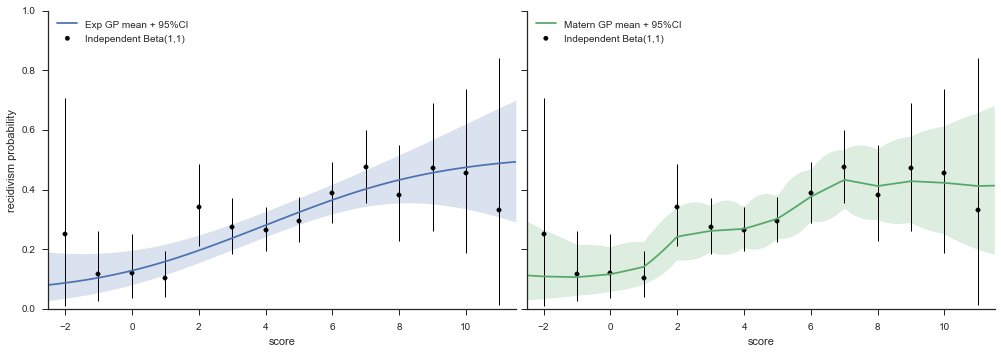

In [6]:
# pull in CDF function so we can display confidence intervals
from GPy.likelihoods.link_functions import std_norm_cdf

# get to posteriour of independent estimates with beta(1,1) prior
d = sps.beta(1+ct[1], 1+ct[0])

# generate some points on which to estimate GP
X = np.linspace(-2.5,11.5,101)

# get some better colors
pal = sns.color_palette()

# to make the plots look nice
with sns.axes_style("ticks"):
    fig,axs = plt.subplots(1,2,sharey=True,figsize=(14,5))

# loop over our two GPs
for i,(ax,m,kern) in enumerate(zip(axs,[mm,me],["Exp","Matern"])):
    # get a prediction from the GP, Y is the mean, Yv is the variance
    Y,Yv = m._raw_predict(X[:,None])
    Y,Yv = m._raw_predict(X[:,None])

    # draw the independent estimates with 95% CI
    ax.scatter(ct.index, d.mean(), label="Independent Beta(1,1)",
               facecolor='k', edgecolor=None)
    ax.vlines(ct.index, d.ppf(0.025), d.ppf(0.975), lw=1)

    # draw the GP mean and 95% CI
    ax.plot(X, std_norm_cdf(Y), color=pal[i], label="%s GP mean + 95%%CI"%(kern,))
    ax.fill_between(X,
                    std_norm_cdf(Y - 2*np.sqrt(Yv))[:,0],
                    std_norm_cdf(Y + 2*np.sqrt(Yv))[:,0],
                    alpha=0.2, color=pal[i], zorder=0)

    # add a figure legend
    ax.legend(loc="upper left")
    # set the axes up nicely
    ax.set_xlim(np.min(X), np.max(X))
    ax.set_ylim(0,1)
    ax.set_xlabel("score")

# just a single label on the y axis
axs[0].set_ylabel("recidivism probability")

# remove lines on the top and right of plot and squeeze everything up nicely
sns.despine()
plt.tight_layout()